## Import libraries and read data 

In [2]:
# Basic data manipulation and plotting
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# ML
from sklearn.preprocessing import StandardScaler
from rdkit.ML.Cluster import Butina

# General RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdFingerprintGenerator, rdMolDescriptors, AllChem 
from rdkit.Chem import PandasTools, rdDepictor, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image

Load fragments from FDA approved drugs:

In [3]:
HERE = Path(_dh[-1])
DATA_FOLDER = HERE.parent.parent/'data'

fda_ring_fragments = pd.read_csv(DATA_FOLDER/'fragments/unique/drug_fragments_no_duplicated.csv')
fda_ring_fragments.head(3)

parent_smiles ring_fragment     chembl_id
0   Cc1cn[nH]c1   Cc1cn[nH]c1    CHEMBL1308
1      C1CNCCN1      C1CNCCN1    CHEMBL1412
2     Nc1ccncc1     Nc1ccncc1  CHEMBL284348

Load FDA approved drugs dataset:

In [4]:
fda_drugs = pd.read_csv(DATA_FOLDER/'fda_approved_datasets/fda_approved_drugs.csv')
fda_drugs[['chembl_id', 'oral']].head(3)

chembl_id  oral
0  CHEMBL1200728  True
1      CHEMBL734  True
2      CHEMBL467  True

Merge dosage form information with Ring Fragments Generated:

In [5]:
# merging info about dosage_form
ring_fragments_dosage_form = pd.merge(fda_ring_fragments, fda_drugs[['chembl_id', 'oral']], on='chembl_id', how='left')
print(ring_fragments_dosage_form.shape)
ring_fragments_dosage_form.head(3)

(3590, 4)


parent_smiles ring_fragment     chembl_id   oral
0   Cc1cn[nH]c1   Cc1cn[nH]c1    CHEMBL1308  False
1      C1CNCCN1      C1CNCCN1    CHEMBL1412   True
2     Nc1ccncc1     Nc1ccncc1  CHEMBL284348   True

### Separate oral/non-oral fragments

In [6]:
ring_fragments_oral = ring_fragments_dosage_form[ring_fragments_dosage_form['oral'] == True]
ring_fragments_oral.head()

parent_smiles    ring_fragment     chembl_id  oral
1         C1CNCCN1         C1CNCCN1    CHEMBL1412  True
2        Nc1ccncc1        Nc1ccncc1  CHEMBL284348  True
3  N[C@@H]1CONC1=O  N[C@@H]1CONC1=O     CHEMBL771  True
4       Nc1ccncc1N       Nc1ccncc1N  CHEMBL354077  True
8        Cn1ccnc1S        Cn1ccnc1S    CHEMBL1515  True

In [7]:
ring_fragments_non_oral = ring_fragments_dosage_form[ring_fragments_dosage_form['oral'] == False]
ring_fragments_non_oral.head()

parent_smiles ring_fragment      chembl_id   oral
0     Cc1cn[nH]c1   Cc1cn[nH]c1     CHEMBL1308  False
5    Oc1cccc(O)c1  Oc1cccc(O)c1    CHEMBL24147  False
6   NCCc1cc[nH]n1   Cc1cc[nH]n1  CHEMBL1201323  False
7   NCCc1c[nH]cn1   Cc1c[nH]cn1       CHEMBL90  False
10  COc1ccc(O)cc1  Oc1ccc(O)cc1      CHEMBL544  False

In [8]:
print(f'There are {ring_fragments_oral.shape[0]} "oral fragments" and\n {ring_fragments_non_oral.shape[0]} "non oral" fragments')

There are 2353 "oral fragments" and
 1237 "non oral" fragments


We can store the information into a list of tuples to make the code run faster.

In [9]:
oral_rfs = []
non_oral_rfs = []

for _, ring_fragment, chembl_id in ring_fragments_oral[['ring_fragment', 'chembl_id']].itertuples():
    oral_rfs.append((Chem.MolFromSmiles(ring_fragment), chembl_id))

for _, ring_fragment, chembl_id in ring_fragments_non_oral[['ring_fragment', 'chembl_id']].itertuples():
    non_oral_rfs.append((Chem.MolFromSmiles(ring_fragment), chembl_id))

print(f"Number of oral ring fragments inserted into the list: {len(oral_rfs)}\nNumber of non oral ring fragments inserted into its list: {len(non_oral_rfs)}.\n\
    Total: {len(oral_rfs)+len(non_oral_rfs)}")

Number of oral ring fragments inserted into the list: 2353
Number of non oral ring fragments inserted into its list: 1237.
    Total: 3590


### Basic stats

A little trick is to use the Counter function from `collections`. Elements from a hashable object are stored as keys in a dictionary and their counts are stored as the dictionary values.

In [10]:
from collections import Counter

# Count the number of rings for oran vs non-oral rfs
oral_ring_counts = [rdMolDescriptors.CalcNumRings(rf) for rf, _ in oral_rfs]
non_oral_ring_counts = [rdMolDescriptors.CalcNumRings(rf) for rf, _ in non_oral_rfs]

print(f"Oral fragments by ring size: {Counter(oral_ring_counts)} Total: {sum(Counter(oral_ring_counts).values())} \nNon-Oral fragments by ring size: {Counter(non_oral_ring_counts)} Total: {sum(Counter(non_oral_rfs).values())}")

Oral fragments by ring size: Counter({1: 1682, 2: 406, 3: 121, 4: 103, 5: 36, 6: 2, 8: 1, 7: 1, 10: 1}) Total: 2353 
Non-Oral fragments by ring size: Counter({1: 830, 2: 187, 4: 119, 3: 63, 5: 28, 7: 4, 8: 2, 10: 2, 11: 1, 6: 1}) Total: 1237


#### Plot basic stats

A visual identification of the information is a very good practice analysing data. Besides the practicality of the `Counter` function, we can plot the frequency of the size (measured as the number of rings in the ring system) of fragments separated by oral and non-oral counterparts.

In [11]:
fig, ax = plt.subplots(1,2, figsize=(21,7))
TITLE_FONT_SIZE = 25
AXIS_FONT_SIZE = 20
TICKS_SIZE = 20

titles = [
    'Oral ring fragments count by ring size',
    'Non-oral ring fragments count by ring size'
]

data = [
    Counter(oral_ring_counts),
    Counter(non_oral_ring_counts)
]

palette = [
    '#b93e3e',
    '#0f6e60'
]

for i in range(2):
    ax[i].bar(data[i].keys(), data[i].values(), color=palette[i])
    ax[i].set_title(titles[i], fontsize=TITLE_FONT_SIZE)
    ax[i].set_xlabel("Number of rings in the ring system", fontsize=AXIS_FONT_SIZE)
    ax[i].tick_params(axis='both', which='major', labelsize=TICKS_SIZE)

# Final adjustments
plt.setp(ax, ylim=ax[0].get_ylim())

[0.0, 1766.1, 0.0, 1766.1]

#### Number of unique fragments

Interesting enough, how many fragments are unique? Using the InChI format for representing unambigously the chemical structure, we are able to count how many unique structures are present in each set (oral vs non oral)

In [12]:
def count_unique_smiles(smiles_list):
    inchi = [Chem.MolToInchi(Chem.MolFromSmiles(smiles)) for smiles in smiles_list]
    n_unique = len(pd.Series(inchi).unique())
    return (f"Total number of SMILES: {len(smiles_list)} (Unique: {n_unique})")

In [13]:
# Disable RDKit warnings for the moment
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  

oral_unique = count_unique_smiles(ring_fragments_oral['ring_fragment'].to_list())
non_oral_unique = count_unique_smiles(ring_fragments_non_oral['ring_fragment'].to_list())

In [14]:
print(oral_unique, '\n',non_oral_unique)

Total number of SMILES: 2353 (Unique: 1098) 
 Total number of SMILES: 1237 (Unique: 616)


## Generate fingerprints, tanimoto sim and dist matrix

The next sections are dedicated to generate fingerprints, compute the similarity between the compounds and the distance matrix.

### Oral)

#### 1) Compute fingerprints

In [15]:
rdkit_fingerprint_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
oral_fingerprints = [rdkit_fingerprint_generator.GetFingerprint(mol) for mol, chembl_id in oral_rfs]

print(f"Number of fp computed: {len(oral_fingerprints)}\
    \nFingerprint length per compound: {len(oral_fingerprints[0])}\
    \nNumber of ring fragments derived from oral compounds: {len(oral_rfs)}")

Number of fp computed: 2353    
Fingerprint length per compound: 2048    
Number of ring fragments derived from oral compounds: 2353


In [16]:
# Example of a fingerprint object inside ou list of fingerprints (i.e. oral_fingerprint)
np.array(oral_fingerprints[0])

array([0, 0, 0, ..., 0, 0, 1])

#### 2) Tanimoto similarity and distance matrix

Helper function to compute the tanimoto distance matrix:

In [17]:
def tanimoto_distance_matrix(fp_list:list) -> list:
    dissimilarity_matrix = []

    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])

    return dissimilarity_matrix

In [18]:
n = len(oral_fingerprints)
elem_triangular_matrix = ( (n*(n-1)) / 2)

print(f"Elements in the triagular matrix = {elem_triangular_matrix} must be equal to\
    \n tanimoto_distance_matrix(oral_fingerprints) = {len(tanimoto_distance_matrix(oral_fingerprints))}")

Elements in the triagular matrix = 2767128.0 must be equal to    
 tanimoto_distance_matrix(oral_fingerprints) = 2767128


Everything seems good so far. We can also investigate the distribution of the mean tanimoto distance between the fragments.

In [19]:

# Oral fragments dist
oral_tanimoto_fragments = tanimoto_distance_matrix(oral_fingerprints)

# Bootstrap to estimate the mean distance
def bootstrap(data, n_iter=1000):
    n_samples = 10
    mean_distribution = np.zeros(n_iter)

    for i in range(n_iter):
        bootstrap_sample = np.random.choice(data, size=n_samples, replace=True)

        # Calculate the mean sim
        mean_distribution[i] = np.sum(bootstrap_sample)/n_samples
    
    return mean_distribution

sns.histplot(bootstrap(data=oral_tanimoto_fragments, n_iter=1000))

<Axes: ylabel='Count'>

#### 3) Cluster, select threshold

In [20]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    
    distance_matrix = tanimoto_distance_matrix(fingerprints) # compute dist matrix

    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)

    return clusters

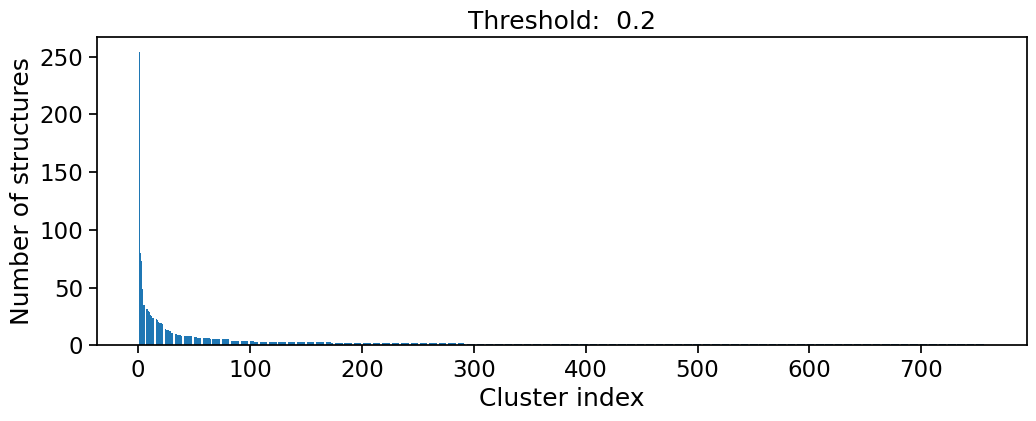

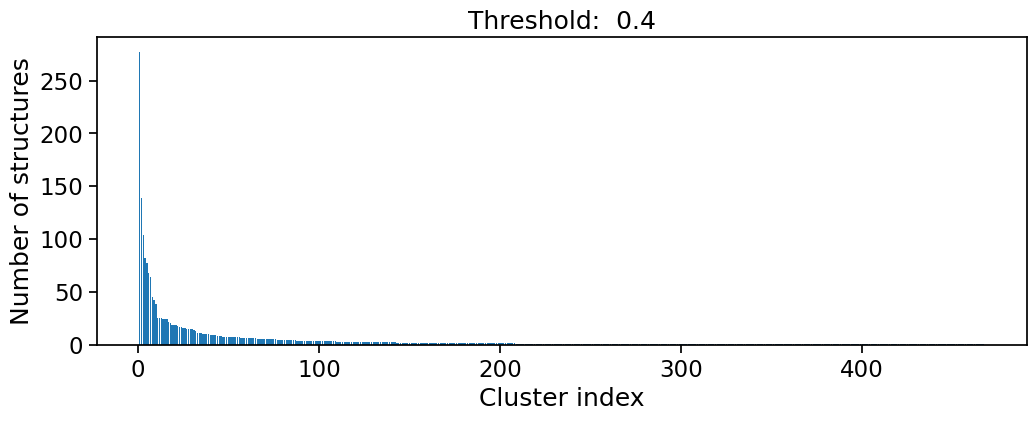

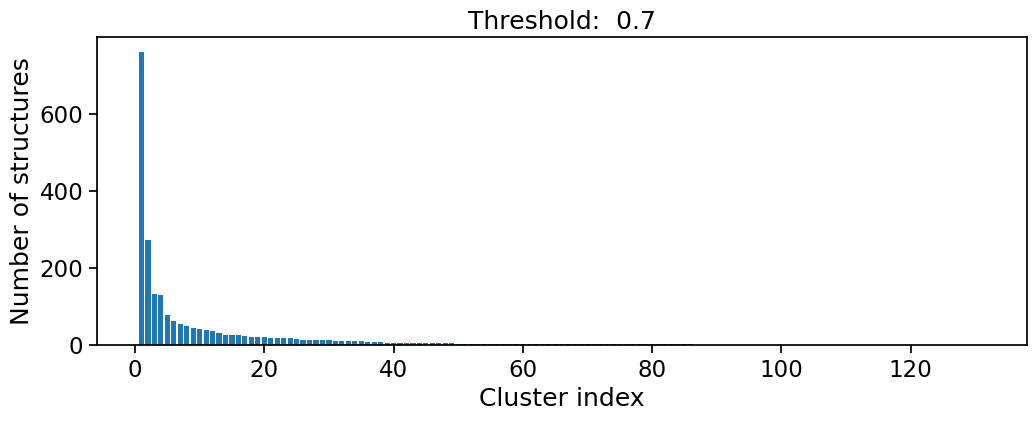

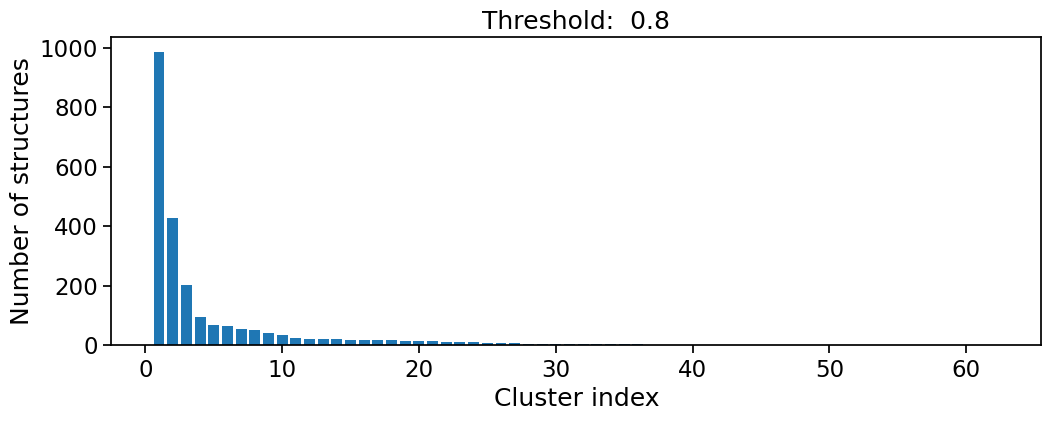

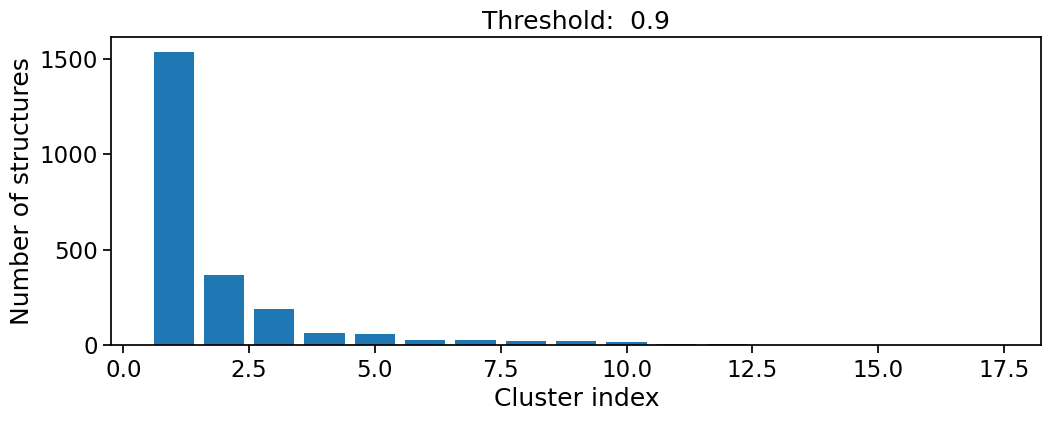

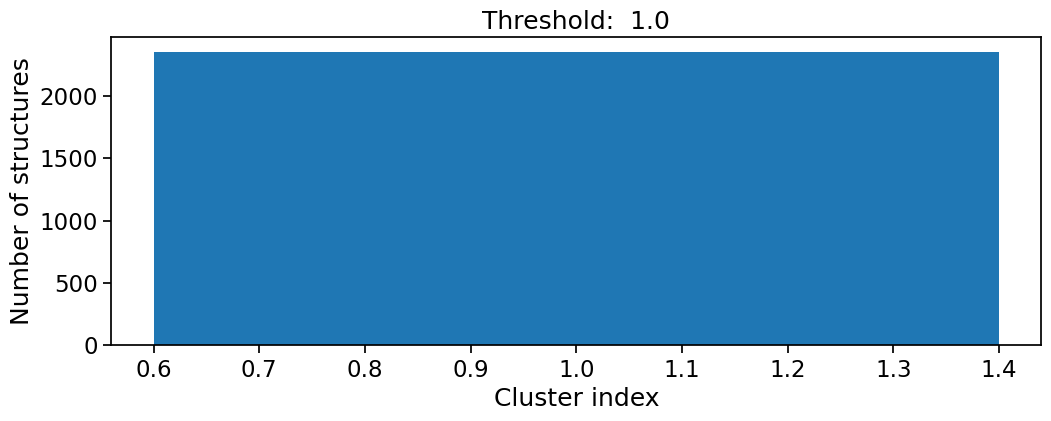

In [21]:
sns.set_context('notebook', font_scale=1.5)
cutoffs = np.arange(0.0, 1.1, 0.1)

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints=oral_fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.set_title(f'Threshold: {cutoff: 3.1f}')
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Number of structures')
    ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], lw=5)

Text(0.5, 1.0, 'Threshold of dissimilarity: 0.1')

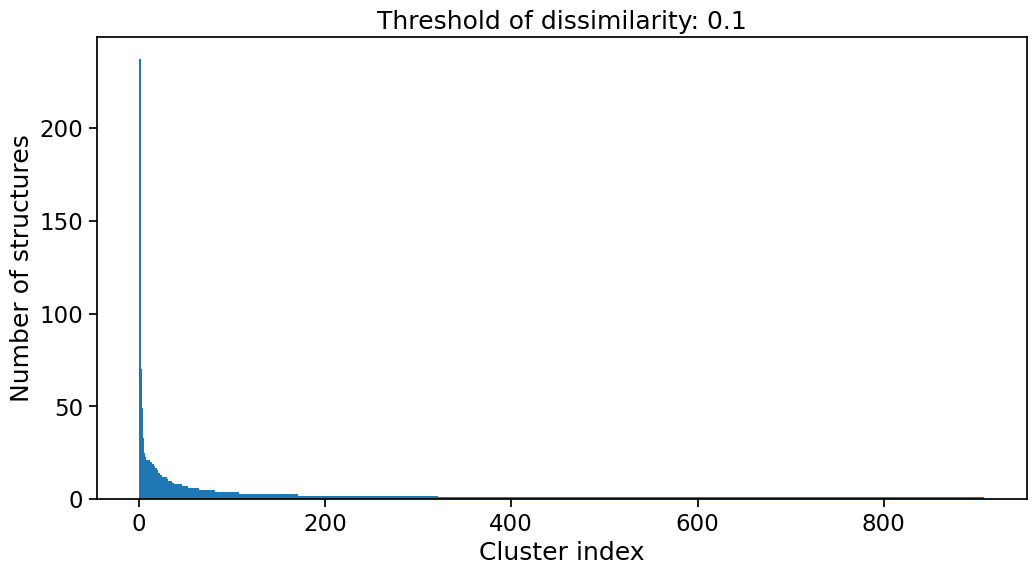

In [22]:
# Final selction of threshold
cutoff = 0.1
oral_clusters = cluster_fingerprints(oral_fingerprints, cutoff=0.1)

#plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of structures')
ax.bar(range(1, len(oral_clusters) + 1), [len(c) for c in oral_clusters], width=2)
ax.set_title(f'Threshold of dissimilarity: {cutoff}')

In [23]:
print(
    f"Number of clusters: {len(oral_clusters)} from {len(oral_rfs)} ring fragments",
    f"\n Number of RF in the first 10 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,10)])}",
    f"\n Number of RF in the first 20 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,20)])}",
    f"\n Number of RF in the first 50 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,50)])}",
    f"\n Number of RF in the first 100 oral_clusters: {sum([len(oral_clusters[x]) for x in range(0,100)])} "
)

Number of clusters: 907 from 2353 ring fragments 
 Number of RF in the first 10 oral_clusters: 528 
 Number of RF in the first 20 oral_clusters: 710 
 Number of RF in the first 50 oral_clusters: 1002 
 Number of RF in the first 100 oral_clusters: 1249 


### Non-oral)

#### 1) Compute fingerprints

In [24]:
rdkit_fingerprint_generator = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
non_oral_fingerprints = [rdkit_fingerprint_generator.GetFingerprint(mol) for mol, chembl_id in non_oral_rfs]

print(f"Number of fp computed: {len(non_oral_fingerprints)}\
    \nFingerprint length per compound: {len(non_oral_fingerprints[0])}\
    \nNumber of ring fragments derived from oral compounds: {len(non_oral_rfs)}")

Number of fp computed: 1237    
Fingerprint length per compound: 2048    
Number of ring fragments derived from oral compounds: 1237


#### 2) Tanimoto similarity and distance matrix

In [25]:
n = len(non_oral_fingerprints)
elem_triangular_matrix = ( (n*(n-1)) / 2)

print(f"Elements in the triagular matrix = {elem_triangular_matrix} must be equal to\
    \n tanimoto_distance_matrix(oral_fingerprints) = {len(tanimoto_distance_matrix(non_oral_fingerprints))}")

Elements in the triagular matrix = 764466.0 must be equal to    
 tanimoto_distance_matrix(oral_fingerprints) = 764466


#### 3) Cluster, select threshold

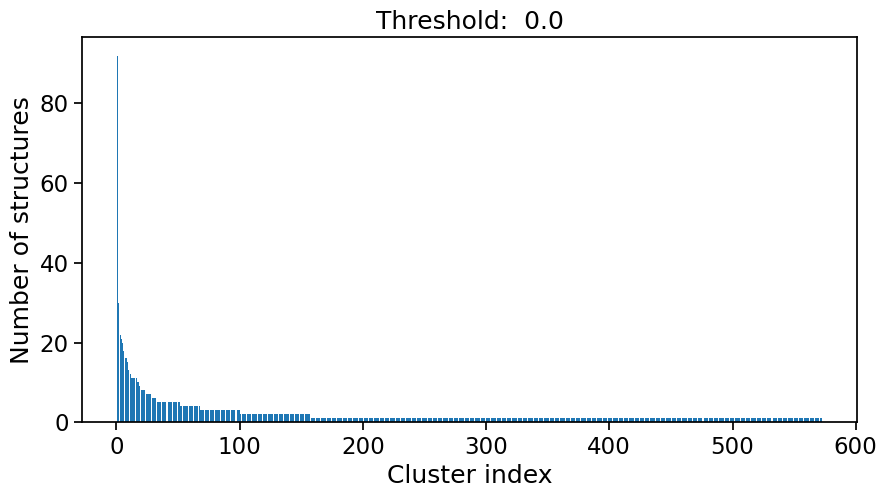

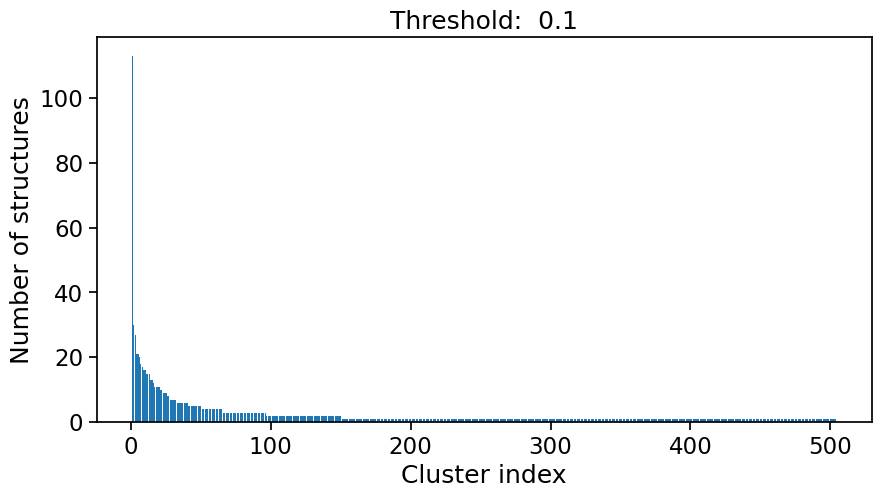

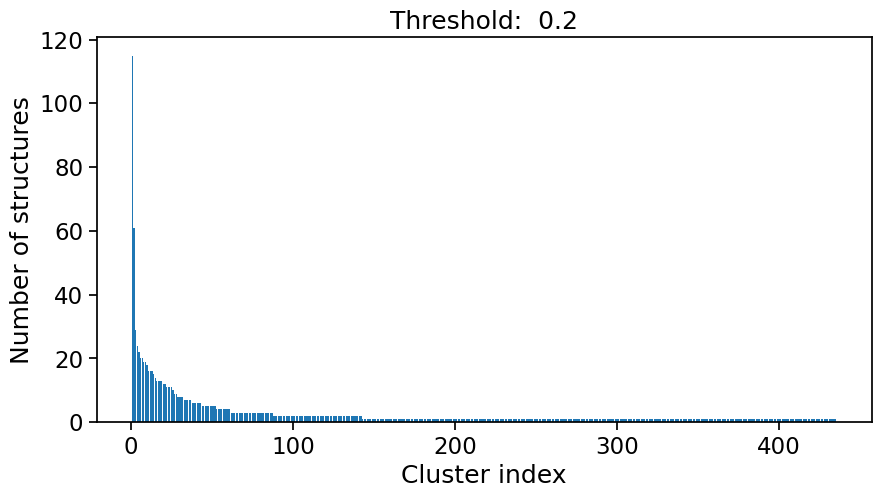

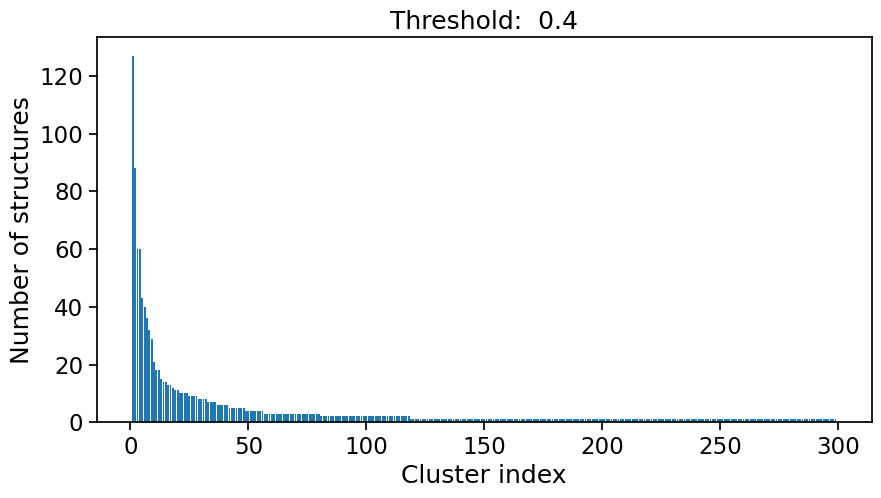

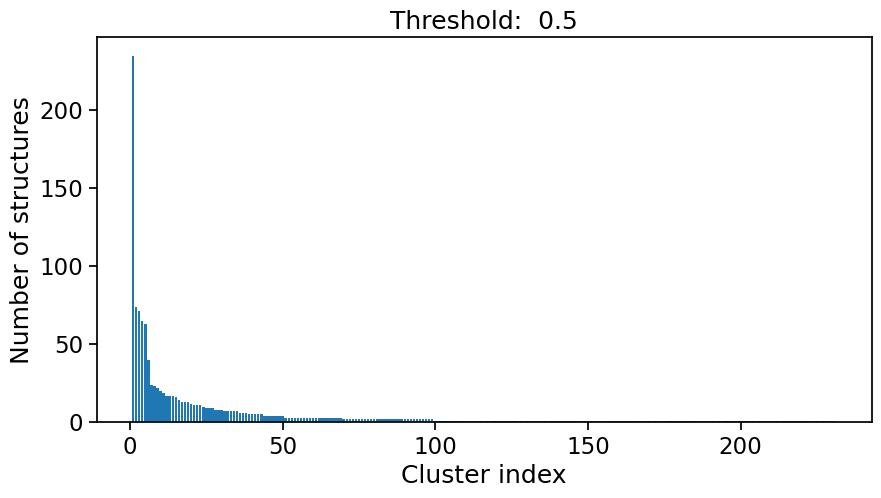

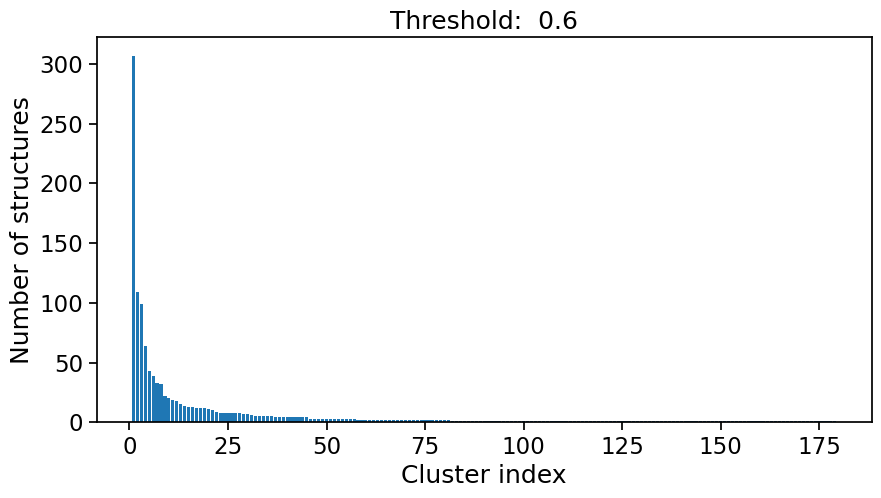

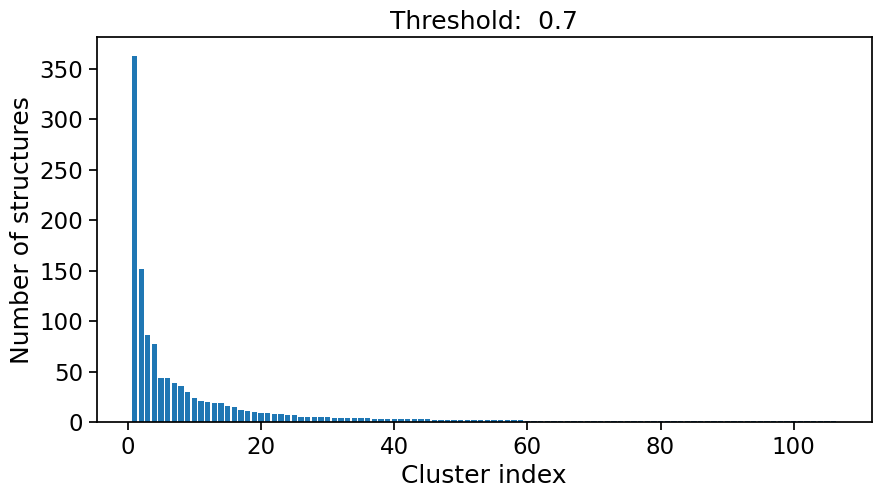

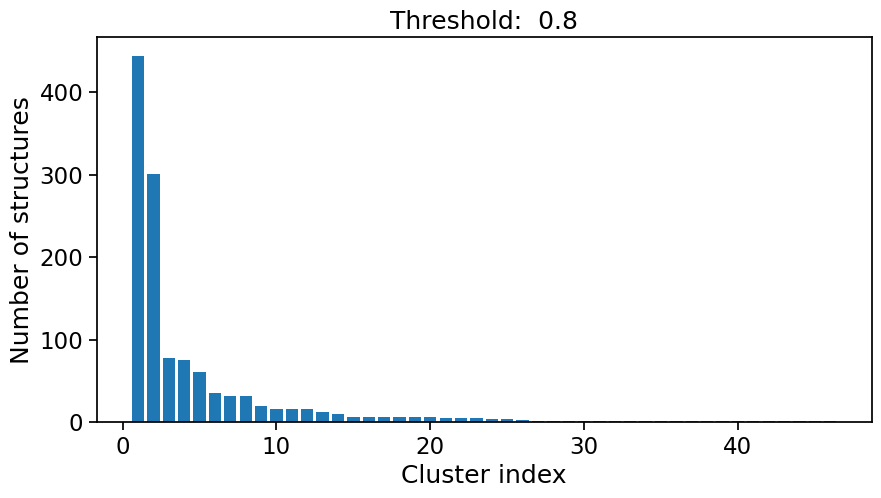

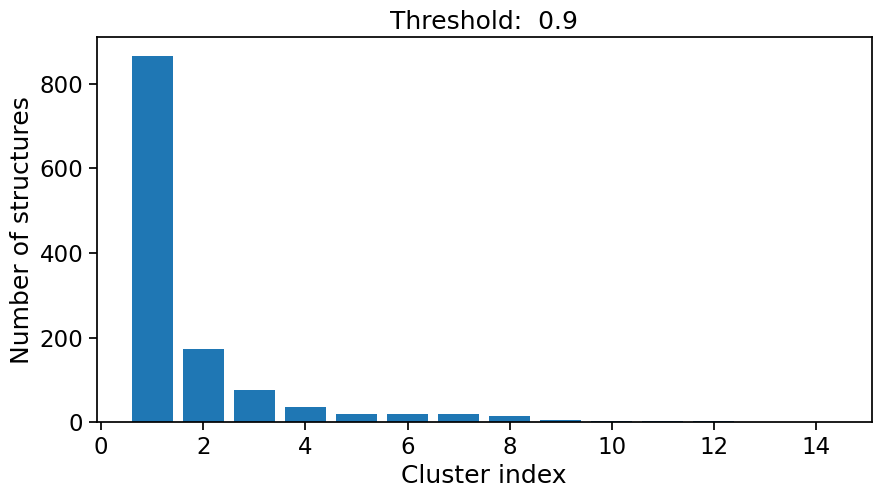

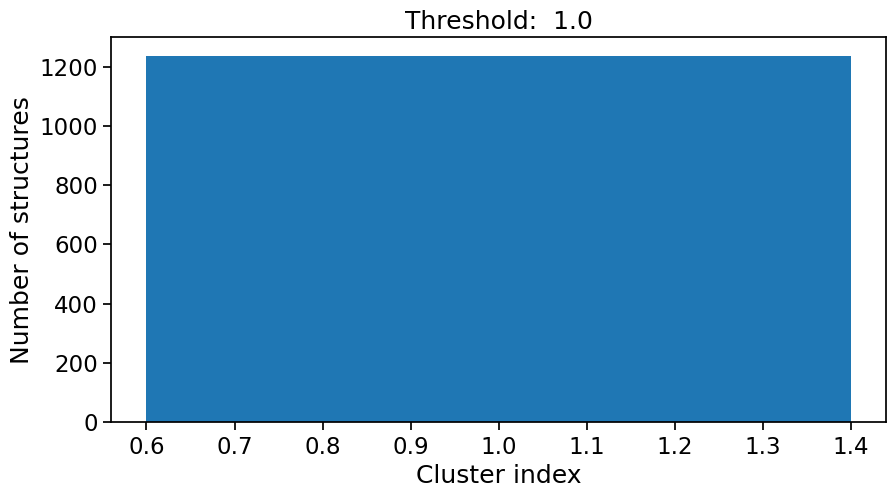

In [26]:
sns.set_context('notebook', font_scale=1.5)
cutoffs = np.arange(0.0, 1.1, 0.1)

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints=non_oral_fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_title(f'Threshold: {cutoff: 3.1f}')
    ax.set_xlabel('Cluster index')
    ax.set_ylabel('Number of structures')
    ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters], lw=5)

Text(0.5, 1.0, 'Threshold of dissimilarity: 0.1')

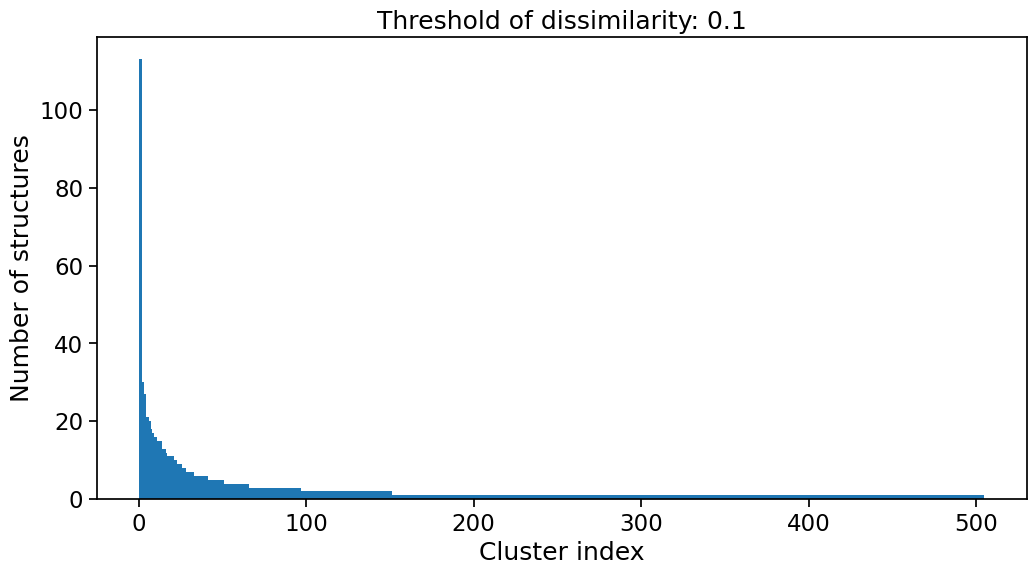

In [27]:
# Final selction of threshold
cutoff = 0.1
non_oral_clusters = cluster_fingerprints(non_oral_fingerprints, cutoff=0.1)

#plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of structures')
ax.bar(range(1, len(non_oral_clusters) + 1), [len(c) for c in non_oral_clusters], width=2)
ax.set_title(f'Threshold of dissimilarity: {cutoff}')

In [28]:
print(
    f"Number of clusters: {len(non_oral_clusters)} from {len(non_oral_rfs)} ring fragments",
    f"\n Number of RF in the first 10 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,10)])}",
    f"\n Number of RF in the first 20 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,20)])}",
    f"\n Number of RF in the first 50 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,50)])}",
    f"\n Number of RF in the first 100 non_oral_clusters: {sum([len(non_oral_clusters[x]) for x in range(0,100)])} "
)

Number of clusters: 504 from 1237 ring fragments 
 Number of RF in the first 10 non_oral_clusters: 299 
 Number of RF in the first 20 non_oral_clusters: 426 
 Number of RF in the first 50 non_oral_clusters: 622 
 Number of RF in the first 100 non_oral_clusters: 783 


## Visualization

We can perform some basic visualization. The options of the visualization can be fine-tuned using the drawing options below, such as fixedFontSize, legendFraction and FontSize. Alway remenber that the IPythonConsole works as a drawing object.

In [29]:
# Drawing options
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.fixedFontSize = 22
IPythonConsole.drawOptions.legendFraction = 0.2
IPythonConsole.drawOptions.legendFontSize = 26
IPythonConsole.drawOptions.setHighlightColour((1,.3,.2,.4))

Defining a simple helper function to return the top n centroids of n clusters.

The n of oral_fragments is: 2353

The n o non_oral_fragments is: 1237

In [30]:
# Helper function to draw top_n centroid clusters
def draw_top_n_centroids(n, clusters, compounds, total_n, **kwargs) -> Draw.MolsToGridImage:
    """
    Returns the GridImage of n cluster centroids.
    Parameters:
    n = number of clusters centroids you want to draw.
    clusters = list of nested cluster indexes.
    compounds = total list of mols
    """
    centroids = [cluster[0] for cluster in clusters[0:n]]
    mols = [compounds[c] for c in centroids]

    molsPerRow = kwargs.get('molsPerRow', 5)
    maxMols = kwargs.get('maxMols', 50)
   
    return Draw.MolsToGridImage(
        mols,
        legends= [f'f: {round((len(c)/total_n)*100,2)}' for c in clusters[0:n]],
        molsPerRow=molsPerRow,
        subImgSize=(300,240),
        maxMols=50
    )

### Oral)

#### Cluster Centroids

/home/gustavo/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


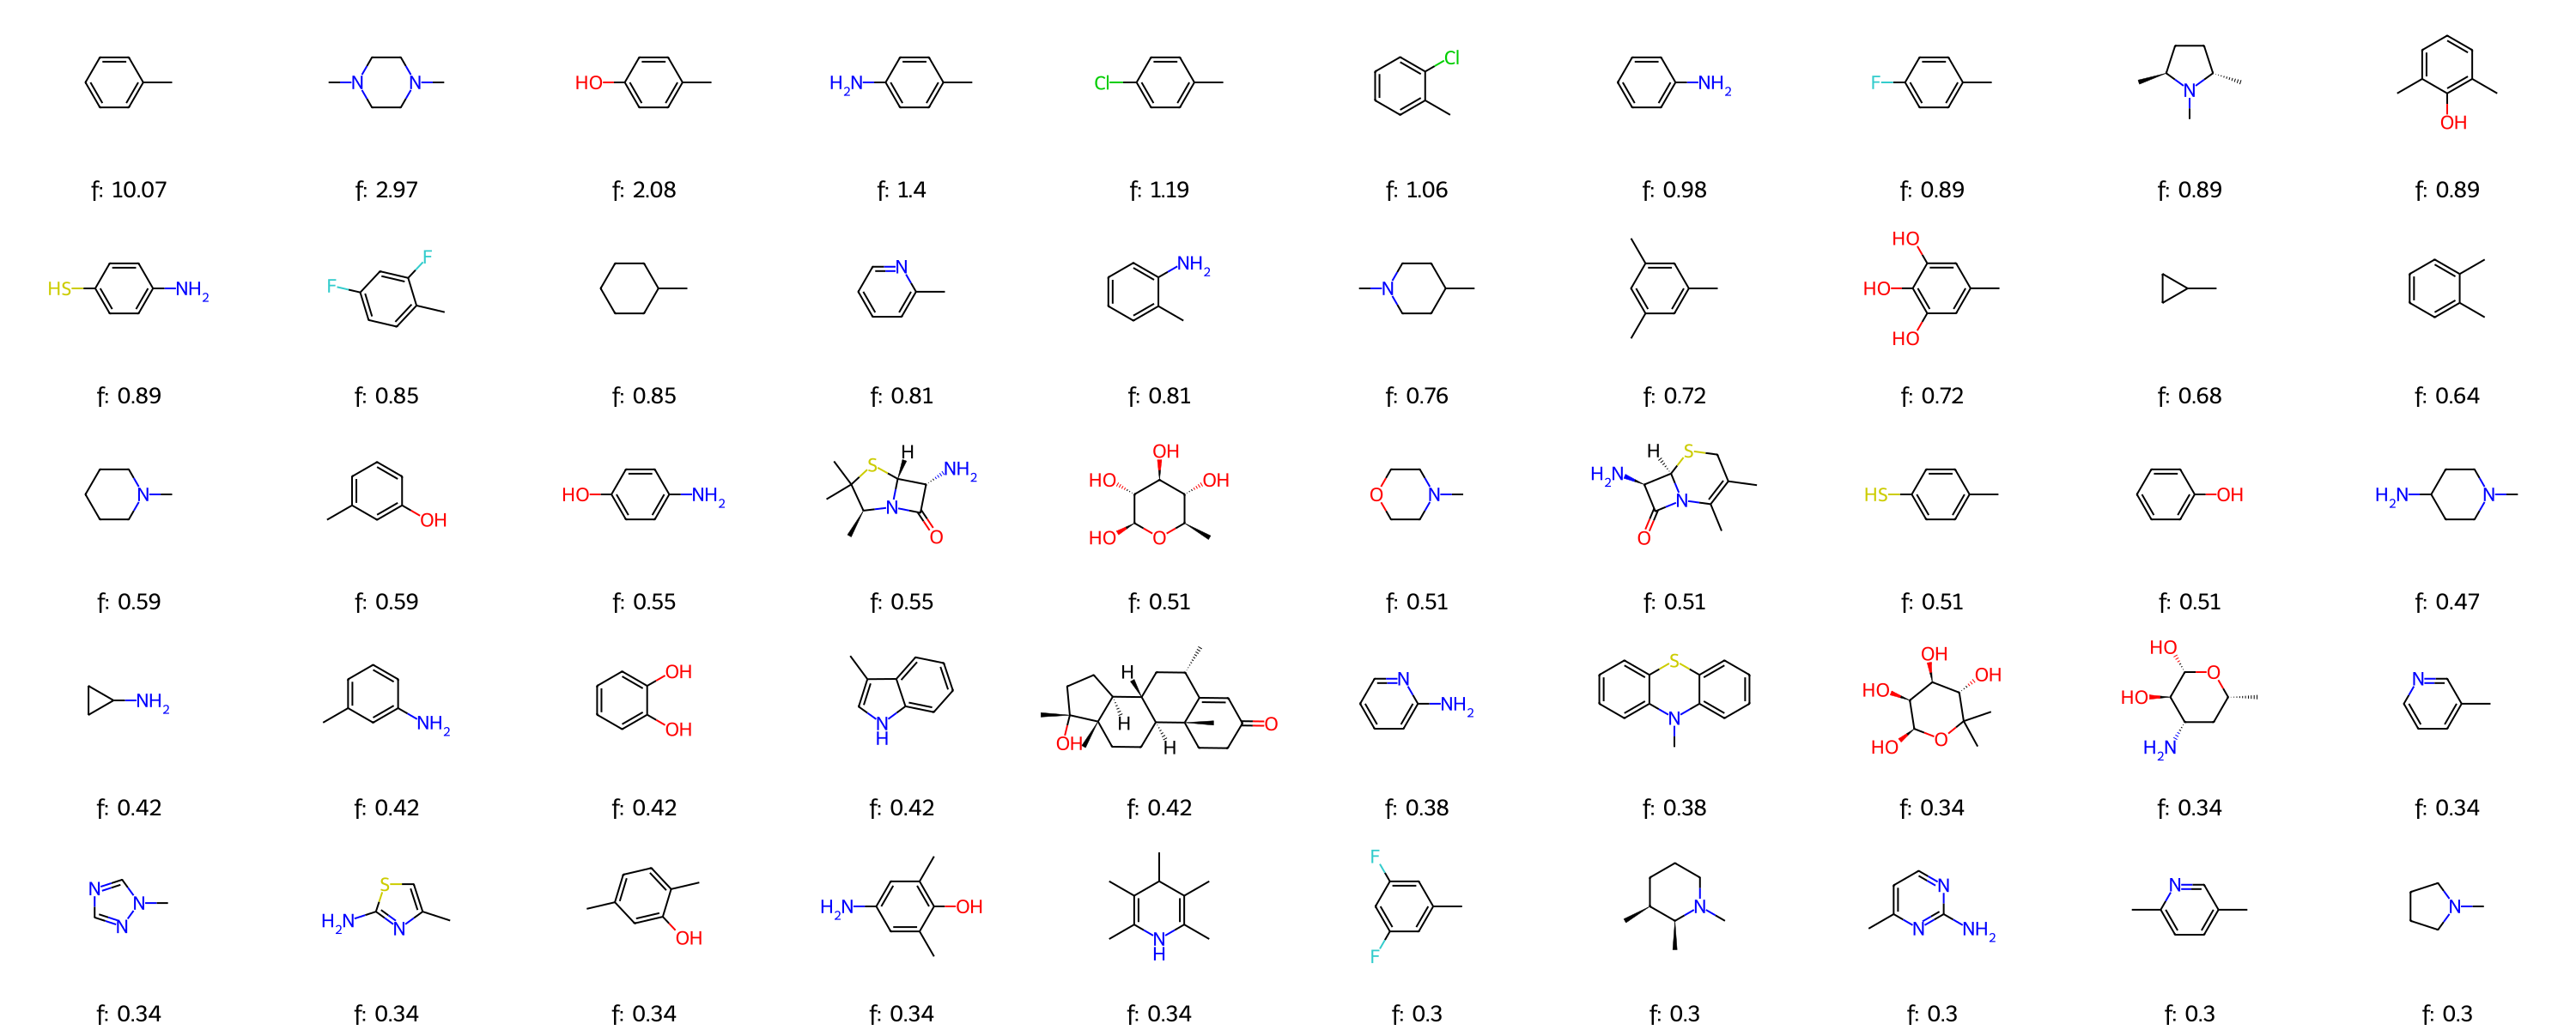

In [31]:
oral_mols = [mol for mol, chembl_id in oral_rfs]
draw_top_n_centroids(100, oral_clusters, oral_mols, 2353,molsPerRow=10)

#### Cluster centroids with highlight

In [32]:
## For each cluster, retrieve a maximum common substructure smarts
def get_clusters_mcs(clusters, mols) -> list:
    """
    Returns a list of cluster mols mcs, must zip with cluster centroids.
    """
    mcs_cluster_mols = []
    
    for cluster in clusters:
        cluster_mols = [mols[idx] for idx in cluster]
        res = rdFMCS.FindMCS(cluster_mols)
        mcs_mol = Chem.MolFromSmarts(res.smartsString)
        mcs_cluster_mols.append(mcs_mol)
    
    return mcs_cluster_mols

In [33]:
n = 100
total_n = 2353 # top n oral mols
oral_mols = [mol for mol, chembl_id in oral_rfs]
oral_mcs_mols = get_clusters_mcs(clusters=oral_clusters[0:n], mols=oral_mols)

# Getting mols of the first n oral_clusters centroids
oral_top_n_centroids = [cluster[0] for cluster in oral_clusters[0:n]]
oral_top_n_mol_centroids = [oral_rfs[i][0] for i in oral_top_n_centroids]

# Getting the matches
oral_highlight = [list(centroid.GetSubstructMatch(mcs)) for mcs, centroid in zip(oral_mcs_mols, oral_top_n_mol_centroids)]

# The legnds for the plot
oral_legends_top_n = [f"f = {round((len(c)/total_n)*100,2)}" for c in oral_clusters[0:n]]

In [34]:
draw_n_mols = 25
Draw.MolsToGridImage(
    oral_top_n_mol_centroids[0:draw_n_mols], 
    highlightAtomLists=oral_highlight[0:draw_n_mols],
    legends=oral_legends_top_n[0:draw_n_mols],
    subImgSize=(300,200), 
    molsPerRow=4)

#### Grouped by ring size:

In [35]:
rings_and_matches = {
    'rings': {
        '1': [],
        '2': [],
        '3': [],
        '4': []
    },
    'matches': {
        '1': [],
        '2': [],
        '3': [],
        '4': []
    },
    'legends': {
        '1': [],
        '2': [],
        '3': [],
        '4': [],
    }
}

# Getting the matches for each cluster by ring size
for mcs, centroid, legends  in zip(oral_mcs_mols, oral_top_n_mol_centroids, oral_legends_top_n):
    n_rings = rdMolDescriptors.CalcNumRings(centroid)

    ring_key = str(min(n_rings, 4))

    rings_and_matches['rings'][ring_key].append(centroid)
    rings_and_matches['matches'][ring_key].append(list(centroid.GetSubstructMatch(mcs)))
    rings_and_matches['legends'][ring_key].append(legends)

In [36]:
def draw_clusters_by_ring_number(rings_matches_dict, n_rings, **kwargs):

    # Optional arguments for function
    molsPerRow = kwargs.get('molsPerRow', 10)
    maxMols = kwargs.get('maxMols', 50)
    subImgSize = kwargs.get('subImgSize', (250, 150))

    mols = rings_matches_dict['rings'][n_rings]
    legend = rings_matches_dict['legends'][n_rings]
    matches = rings_matches_dict['matches'][n_rings]

    return Draw.MolsToGridImage(
        mols,
        legends = legend,
        highlightAtomLists = matches,
        subImgSize = subImgSize,
        molsPerRow = molsPerRow,
        maxMols = maxMols
    )

#### 1) One ring

In [37]:
IPythonConsole.drawOptions.setHighlightColour((1,.3,.2,.4))

/home/gustavo/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 30. Change the maxMols value to display more.
  warnings.warn(


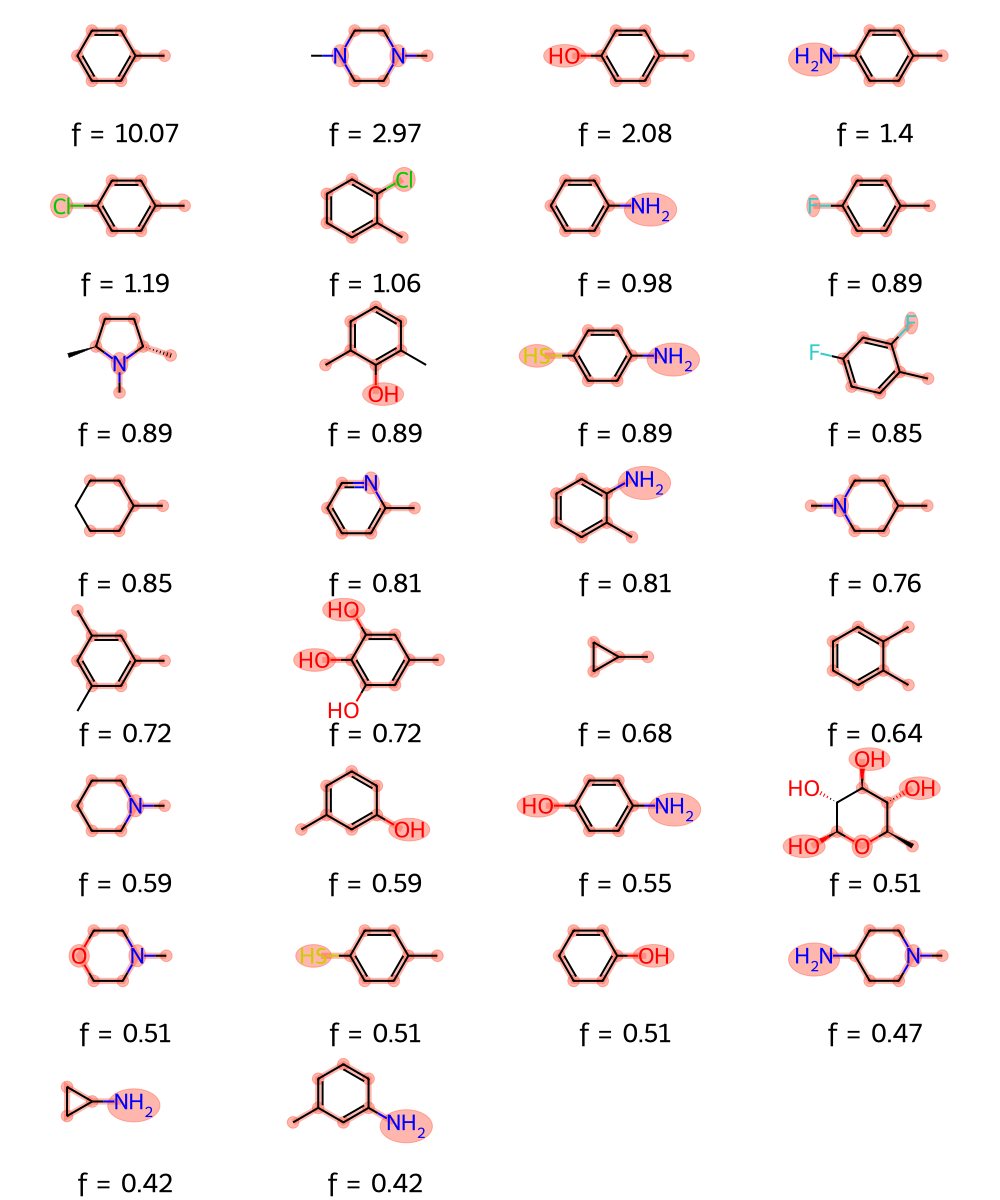

In [38]:
draw_clusters_by_ring_number(rings_and_matches, n_rings=str(1), molsPerRow=4, maxMols=30)

#### 2) Two rings

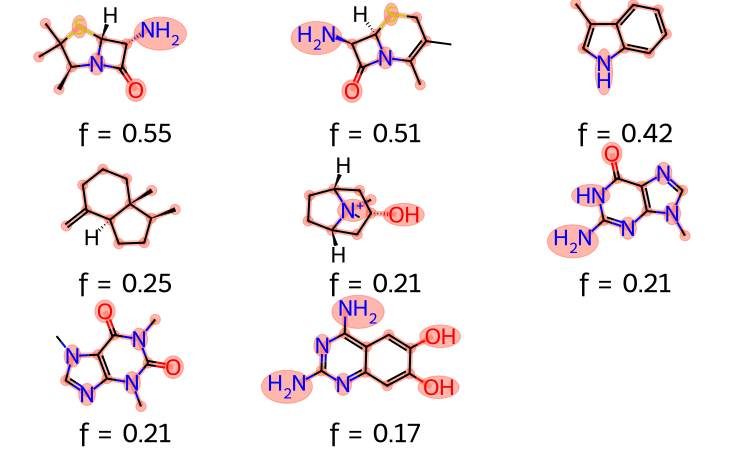

In [39]:
draw_clusters_by_ring_number(rings_and_matches, n_rings=str(2), molsPerRow=3)

#### 3) Three rings

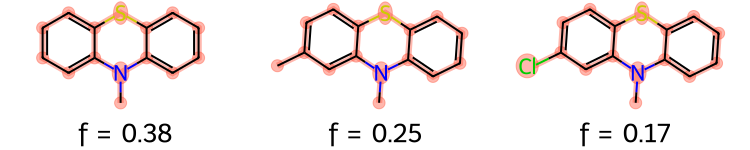

In [40]:
draw_clusters_by_ring_number(rings_and_matches, n_rings=str(3), molsPerRow=3)

#### 4) Four or more rings

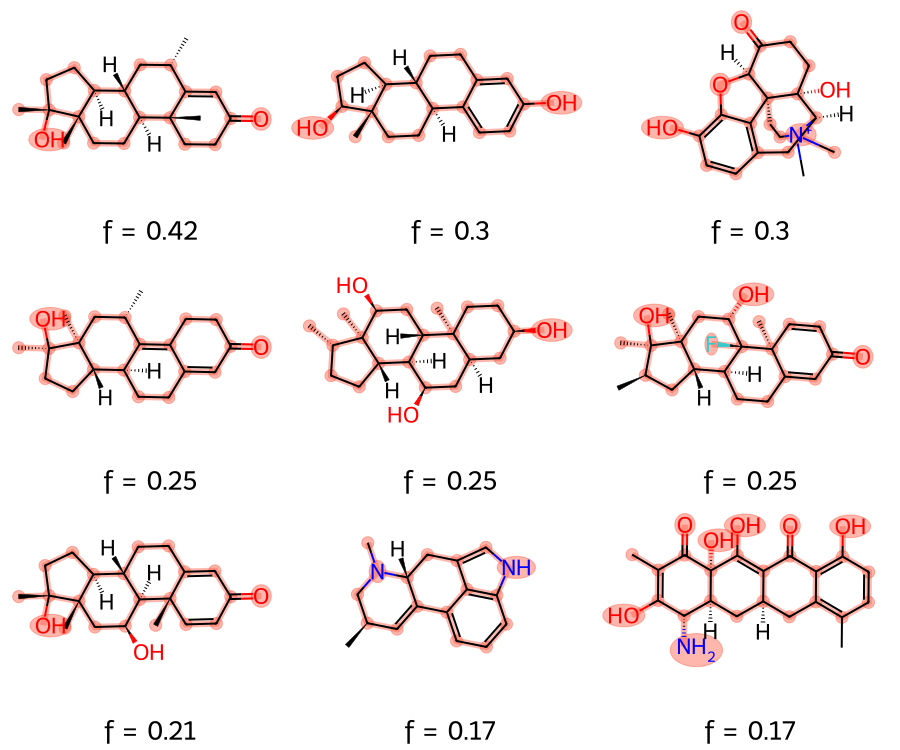

In [41]:
draw_clusters_by_ring_number(rings_and_matches, n_rings=str(4), molsPerRow=3, subImgSize=(300,250))

### Non-oral)

#### Cluster centroids

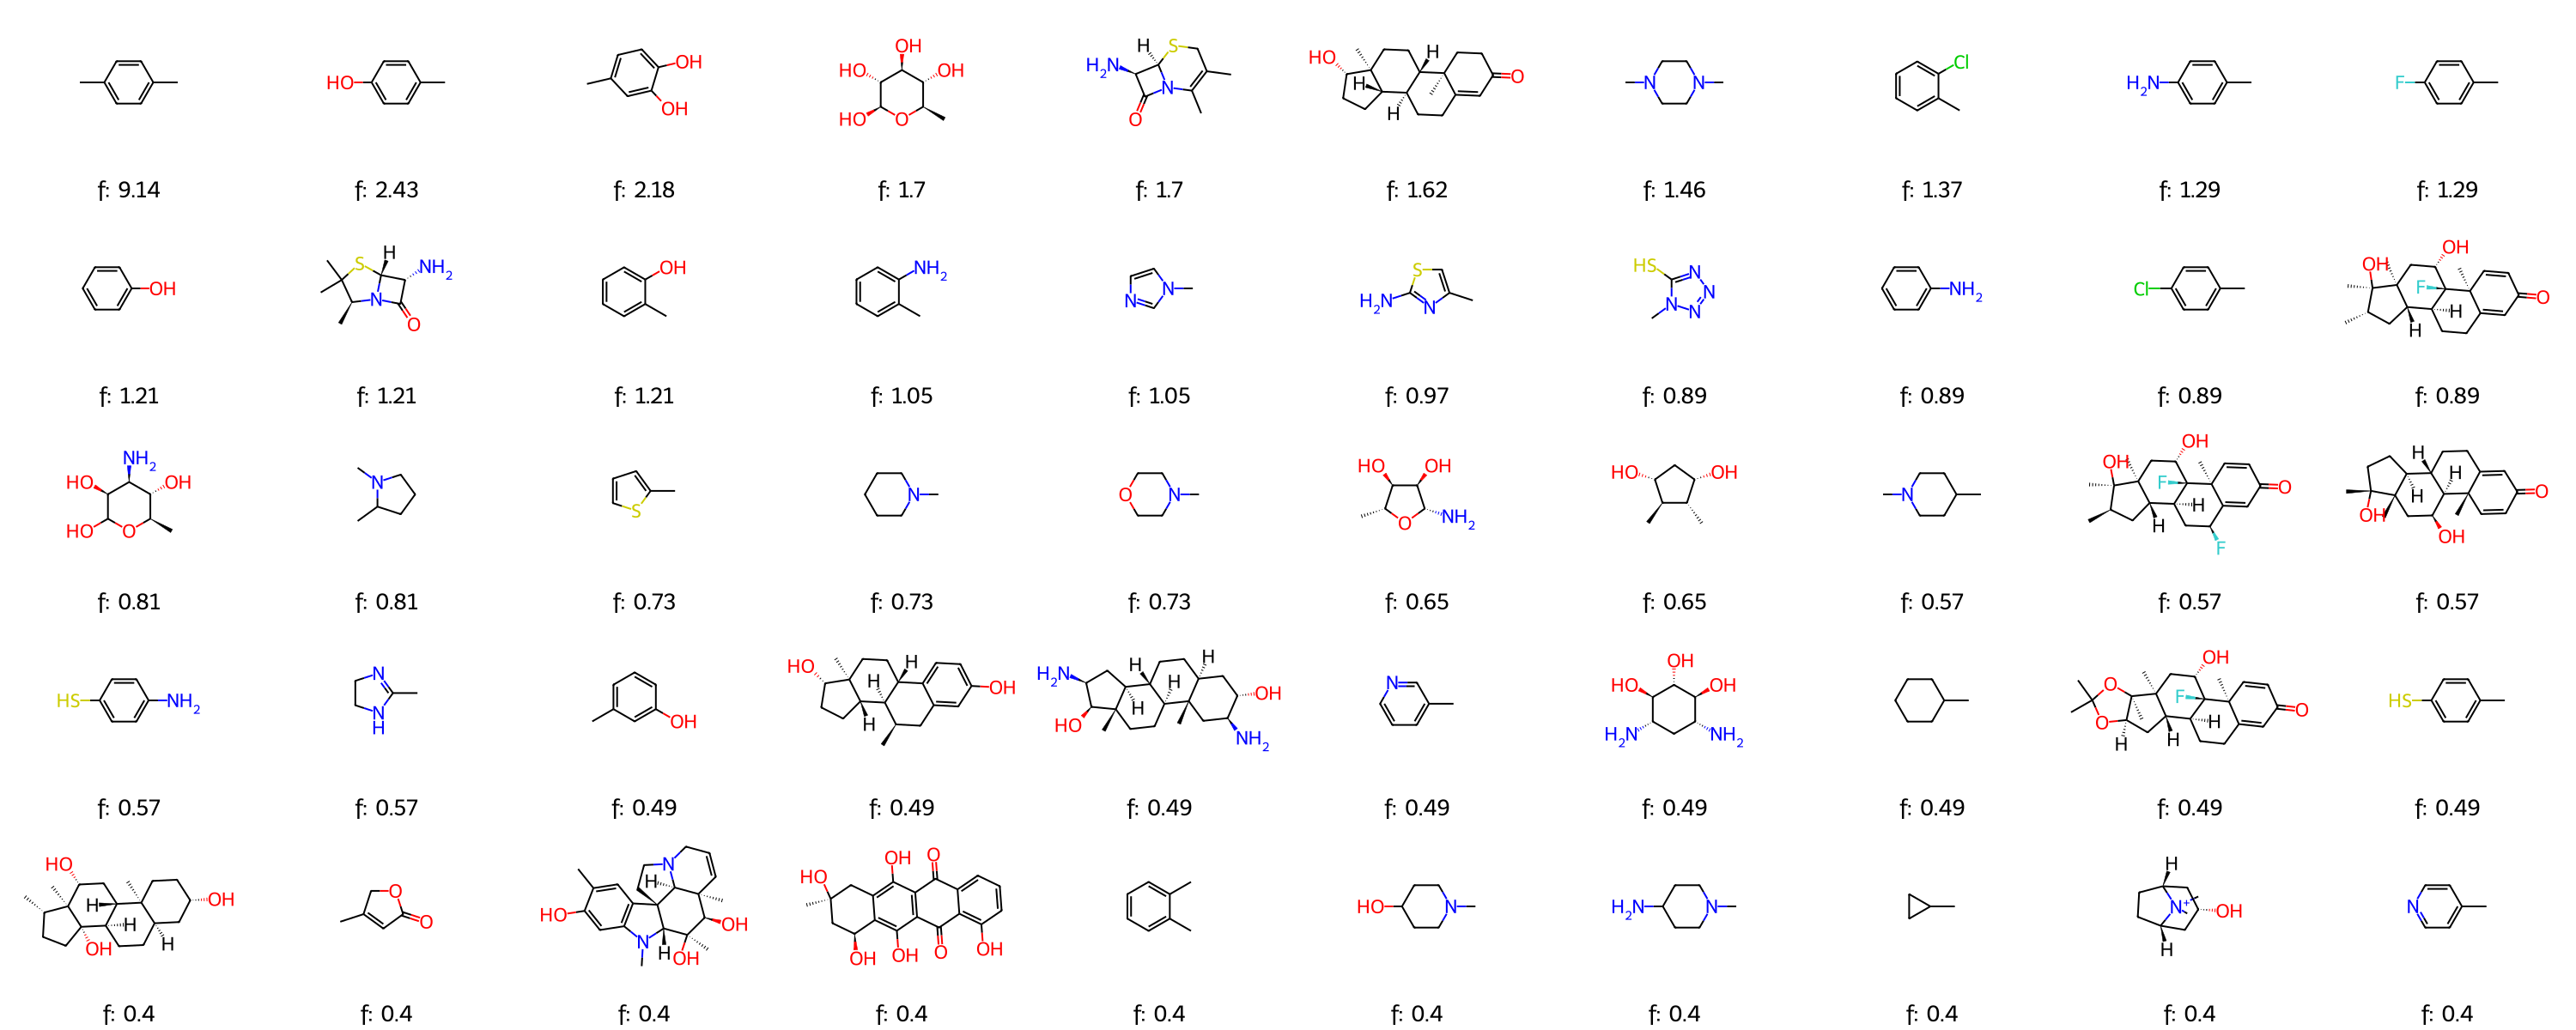

In [42]:
non_oral_mols =  [mol for mol, chembl_id in non_oral_rfs]
draw_top_n_centroids(100, non_oral_clusters, non_oral_mols, 1237,molsPerRow=10)

#### Cluster centroid with highlights

In [43]:
n = 100 # top n non oral mols
total_n = 1237
non_oral_mols = [mol for mol, chembl_id in non_oral_rfs]
non_oral_mcs_mols = get_clusters_mcs(clusters=non_oral_clusters[0:n], mols=non_oral_mols)

# Getting mols of the first n non_oral clusters centroids
non_oral_top_n_centroids = [cluster[0] for cluster in non_oral_clusters[0:n]]
non_oral_top_n_mol_centroids = [non_oral_rfs[i][0] for i in non_oral_top_n_centroids]

# Matches of the MCS
non_oral_highlight = [list(centroid.GetSubstructMatch(mcs)) for mcs, centroid in zip(non_oral_mcs_mols, non_oral_top_n_mol_centroids)]

# The legends for the plot
non_oral_legends_top_n = [f"f = {round((len(c)/total_n)*100,2)}" for c in non_oral_clusters[0:n]]

In [44]:
IPythonConsole.drawOptions.setHighlightColour((.4,.8,.5,.4))
draw_n_mols = 25
Draw.MolsToGridImage(
    non_oral_top_n_mol_centroids[0:draw_n_mols], 
    highlightAtomLists=non_oral_highlight[0:draw_n_mols],
    legends=non_oral_legends_top_n[0:draw_n_mols],
    subImgSize=(300,200), 
    molsPerRow=4)

#### Grouped by Ring size

In [45]:
non_oral_rings_and_matches = {
    'rings':{
        '1': [],
        '2': [],
        '3': [],
        '4': [],
    },
    'matches': {
        '1': [],
        '2': [],
        '3': [],
        '4': []
    },
    'legends': {
        '1': [],
        '2': [],
        '3': [],
        '4': []
    }
}

# getting the matches for each cluster by ring size
for mcs, centroid, legends in zip(non_oral_mcs_mols, non_oral_top_n_mol_centroids, non_oral_legends_top_n):
    n_rings = rdMolDescriptors.CalcNumRings(centroid)

    ring_key = str(min(n_rings, 4))
    
    non_oral_rings_and_matches['rings'][ring_key].append(centroid)
    non_oral_rings_and_matches['matches'][ring_key].append(list(centroid.GetSubstructMatch(mcs)))
    non_oral_rings_and_matches['legends'][ring_key].append(legends)

#### 1) One ring

In [46]:
draw_clusters_by_ring_number(non_oral_rings_and_matches, n_rings=str(1), molsPerRow=4, maxMols=30)

#### 2) Two rings

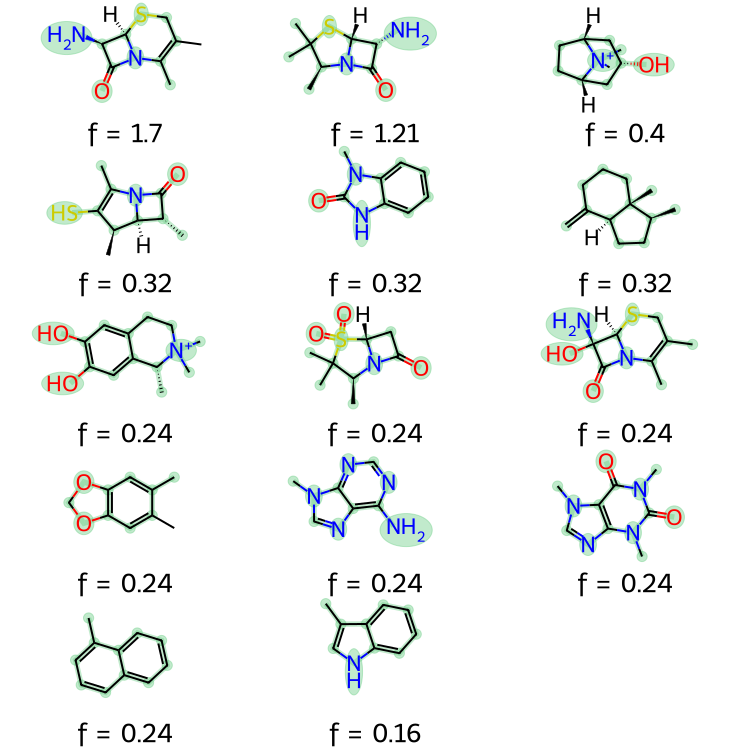

In [47]:
draw_clusters_by_ring_number(non_oral_rings_and_matches, n_rings=str(2), molsPerRow=3)

#### 3) Three rings

/home/gustavo/miniconda3/envs/teachopencadd/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:258: UserWarning: Truncating the list of molecules to be displayed to 2. Change the maxMols value to display more.
  warnings.warn(


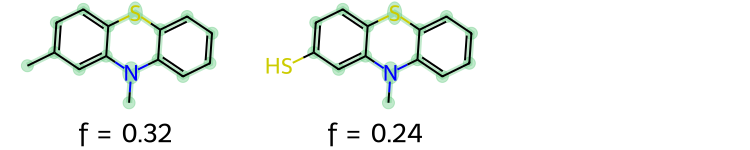

In [48]:
draw_clusters_by_ring_number(non_oral_rings_and_matches, n_rings=str(3), molsPerRow=3, maxMols=2)

#### 4) Four rings

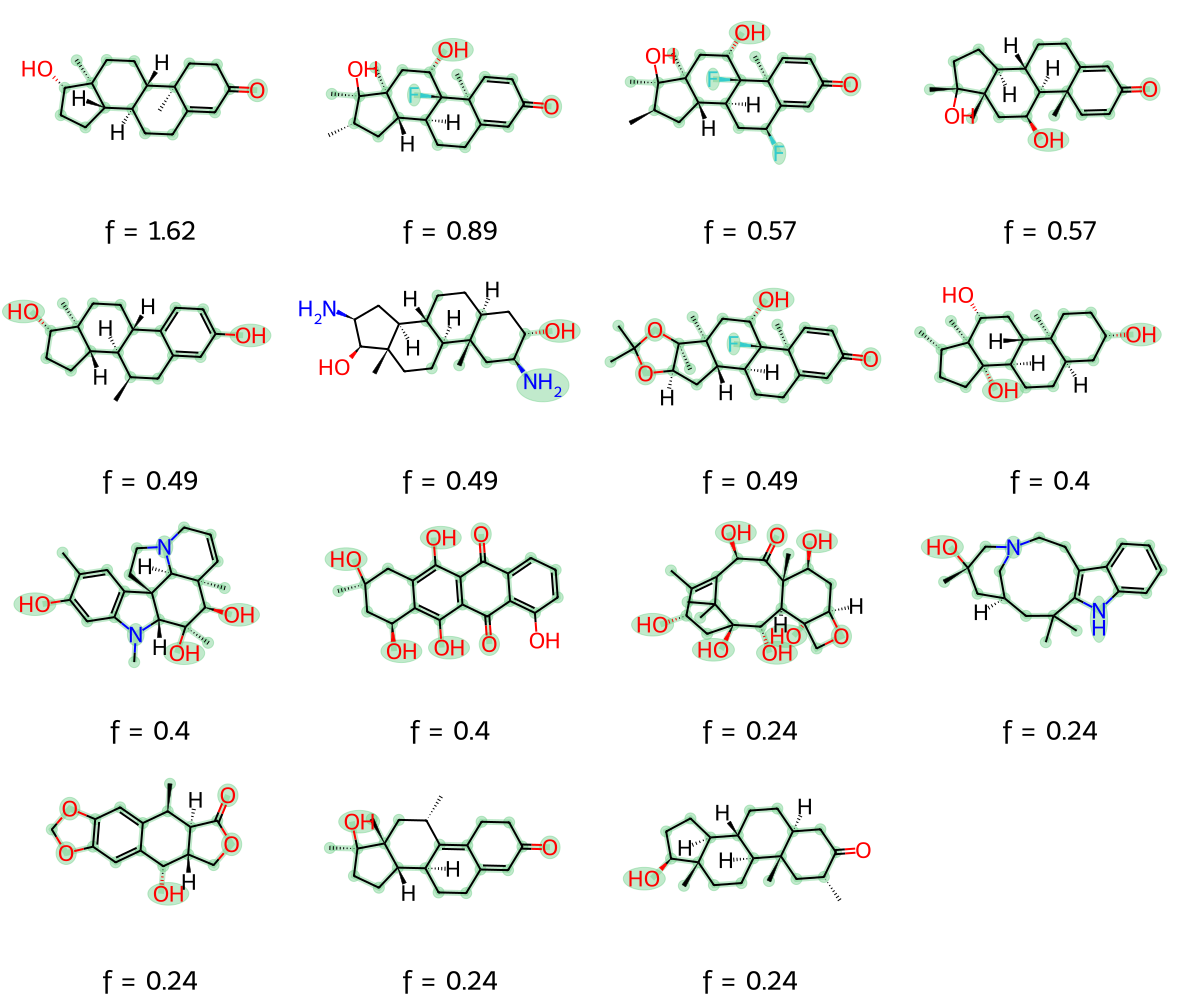

In [49]:
draw_clusters_by_ring_number(non_oral_rings_and_matches, n_rings=str(4), molsPerRow=4, subImgSize=(300,250))

## Compare differences

It is very hard to notice any difference whatsoever on the `Top 100` "oral" and the "non-oral" counterpart. They seem to have different chemical fragments profiles but some basic questions that I want to investigate further are:

* Compute the relative frequencies (f%) of each fragment. 
  * Compare the (f%) of the fragments that appear both on the `Top 100` "oral" and "non-oral" fragments. 
  * If the (f%) of common fragment is 2x or 3x between groups, select. 
* Compute of the `Top 100` common fragments, which ones appear only in the "oral" or "non-oral" counterpart.

In [62]:
## For each cluster, retrieve a maximum common substructure smarts
# def get_clusters_mcs(clusters, mols) -> list:
#     """
#     Returns a list of cluster mols mcs, must zip with cluster centroids.
#     """
#     mcs_cluster_mols = []
    
#     for cluster in clusters:
#         cluster_mols = [mols[idx] for idx in cluster]
#         res = rdFMCS.FindMCS(cluster_mols)
#         mcs_mol = Chem.MolFromSmarts(res.smartsString)
#         mcs_cluster_mols.append(mcs_mol)
    
#     return mcs_cluster_mols

Below is the helper function to generate the relative frequency table of each set of ring fragments.

In [78]:
def get_frequency_df(top_n, total_n_rfs, mol_id_tuple, clusters):

    # Computing the MCS
    mols = [mol for mol, chembl_id in mol_id_tuple]
    mcs_mols = get_clusters_mcs(clusters=clusters[0:top_n], mols=mols)

    # The mols of the first n centroids
    top_n_centroids = [cluster[0] for cluster in clusters[0:top_n]] # The centroid is the first item in the cluster
    top_n_mol_centroids = [mol_id_tuple[i][0] for i in top_n_centroids]

    # Matches and size of each cluster
    highlight = [list(centroid.GetSubstructMatch(mcs)) for mcs, centroid in zip(mcs_mols, top_n_mol_centroids)]
    cluster_size = [round((len(c)/total_n_rfs)*100, 2) for c in clusters[0:top_n]]

    # The SMILES
    top_n_smiles_centroids = [Chem.MolToSmiles(mol) for mol in top_n_mol_centroids]

    # The frequency dataframe
    dict_results = []
    for smiles, mol, mcs, size in zip(top_n_smiles_centroids, top_n_mol_centroids, highlight, cluster_size):
        dict_results.append({"smiles": smiles, "mol": mol, "mcs_index": mcs, "size": size})

    return pd.DataFrame(dict_results)


### Basal frequency

What are the base frequency of each fragment group, i. e.what is the relative frequency that n = 1?

In [106]:
total_n_non_oral
total_n_oral
print(f"Total number of oral fragments: {total_n_oral}, total number of non oral fragments: {total_n_non_oral}\
    \nThe n = 4  for the oral cluster size is {round((4/total_n_oral)*100, 2)}%\
    \n The n = 4 for the non oral cluster size is {round((4/total_n_non_oral)*100, 2)}%")

Total number of oral fragments: 2353, total number of non oral fragments: 1237    
The n = 4  for the oral cluster size is 0.17%    
 The n = 4 for the non oral cluster size is 0.32%


### Oral dataframe

In [104]:
frequency_oral_df = get_frequency_df(top_n=100, total_n_rfs=2353, mol_id_tuple=oral_rfs, clusters=oral_clusters)
frequency_oral_df['group'] = "oral"
frequency_oral_df

smiles  \
0                   Cc1ccccc1   
1                CN1CCN(C)CC1   
2                Cc1ccc(O)cc1   
3                Cc1ccc(N)cc1   
4               Cc1ccc(Cl)cc1   
..                        ...   
95              Cc1ccc(N)cc1F   
96               Cc1noc(C)c1C   
97   Nc1nc(N)c2cc(O)c(O)cc2n1   
98        C[C@H]1CN(C)C(=O)O1   
99  CN1c2ccccc2Sc2ccc(Cl)cc21   

                                                 mol  \
0   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12e040>   
1   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12c9a0>   
2   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12b1c0>   
3   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12e340>   
4   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12cb80>   
..                                               ...   
95  <rdkit.Chem.rdchem.Mol object at 0x7f14cd115ca0>   
96  <rdkit.Chem.rdchem.Mol object at 0x7f14cd113d60>   
97  <rdkit.Chem.rdchem.Mol object at 0x7f14cd112100>   
98  <rdkit.Chem.rdchem.Mol object at 0x7f14cd110940>   
99  <rdkit.Chem.rdchem.Mol object at 0x7f14cd10ebe0>   

                                            mcs_index   size group  
0                               [0, 1, 2, 3, 4, 5, 6]  10.07  oral  
1                               [0, 1, 2, 3, 4, 6, 7]   2.97  oral  
2                            [0, 1, 2, 3, 4, 6, 7, 5]   2.08  oral  
3                            [0, 1, 2, 3, 4, 6, 7, 5]   1.40  oral  
4                            [0, 1, 2, 3, 4, 6, 7, 5]   1.19  oral  
..                                                ...    ...   ...  
95                        [0, 1, 2, 3, 4, 6, 7, 8, 5]   0.17  oral  
96                           [0, 1, 2, 3, 4, 6, 7, 5]   0.17  oral  
97     [0, 1, 2, 3, 4, 5, 12, 13, 11, 9, 7, 6, 8, 10]   0.17  oral  
98                           [0, 1, 2, 3, 5, 7, 6, 4]   0.17  oral  
99  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 15, 14, 12, 11,...   0.17  oral  

[100 rows x 5 columns]

In [105]:
# Selecting only clusters with n > 4
frequency_oral_df = frequency_oral_df.loc[frequency_oral_df['size'] > 0.17].reset_index(drop=True)
frequency_oral_df

smiles  \
0                    Cc1ccccc1   
1                 CN1CCN(C)CC1   
2                 Cc1ccc(O)cc1   
3                 Cc1ccc(N)cc1   
4                Cc1ccc(Cl)cc1   
..                         ...   
76               Cc1nccc(O)c1C   
77    Cn1cnc2c(=O)[nH]c(N)nc21   
78                CC1(N)CCCCC1   
79  Cn1c(=O)c2c(ncn2C)n(C)c1=O   
80      CC1(C)C(=O)NC(=O)NC1=O   

                                                 mol  \
0   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12e040>   
1   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12c9a0>   
2   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12b1c0>   
3   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12e340>   
4   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12cb80>   
..                                               ...   
76  <rdkit.Chem.rdchem.Mol object at 0x7f14cd17a3a0>   
77  <rdkit.Chem.rdchem.Mol object at 0x7f14cd177340>   
78  <rdkit.Chem.rdchem.Mol object at 0x7f14cd174e80>   
79  <rdkit.Chem.rdchem.Mol object at 0x7f14cd16fbe0>   
80  <rdkit.Chem.rdchem.Mol object at 0x7f14cd14fb80>   

                                      mcs_index   size group  
0                         [0, 1, 2, 3, 4, 5, 6]  10.07  oral  
1                         [0, 1, 2, 3, 4, 6, 7]   2.97  oral  
2                      [0, 1, 2, 3, 4, 6, 7, 5]   2.08  oral  
3                      [0, 1, 2, 3, 4, 6, 7, 5]   1.40  oral  
4                      [0, 1, 2, 3, 4, 6, 7, 5]   1.19  oral  
..                                          ...    ...   ...  
76                  [0, 1, 2, 3, 4, 5, 7, 8, 6]   0.21  oral  
77       [0, 1, 2, 3, 4, 11, 10, 8, 7, 5, 6, 9]   0.21  oral  
78                        [0, 1, 2, 3, 4, 5, 6]   0.21  oral  
79  [0, 1, 2, 3, 4, 8, 7, 6, 5, 10, 12, 13, 11]   0.21  oral  
80           [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 7]   0.21  oral  

[81 rows x 5 columns]

### Non oral dataframe

In [111]:
frequency_non_oral_df = get_frequency_df(top_n=100, total_n_rfs=1237, mol_id_tuple=non_oral_rfs, clusters=non_oral_clusters)
frequency_non_oral_df['group'] = "non oral"
frequency_non_oral_df

smiles  \
0                                        Cc1ccc(C)cc1   
1                                        Cc1ccc(O)cc1   
2                                     Cc1ccc(O)c(O)c1   
3          C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O   
4                   CC1=C(C)N2C(=O)[C@@H](N)[C@H]2SC1   
..                                                ...   
95                                     Cn1ccc(N)nc1=O   
96                                  Cc1c[nH]c2ccccc12   
97                                        Cc1csc(C)n1   
98                                        Cc1nnn[nH]1   
99  C[C@@H]1NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@H](C...   

                                                 mol  \
0   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dfe80>   
1   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e0040>   
2   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dfee0>   
3   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e0520>   
4   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dbf40>   
..                                               ...   
95  <rdkit.Chem.rdchem.Mol object at 0x7f14cd137f40>   
96  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e05e0>   
97  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e02e0>   
98  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dffa0>   
99  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dff40>   

                                            mcs_index  size     group  
0                               [0, 1, 2, 3, 4, 6, 7]  9.14  non oral  
1                            [0, 1, 2, 3, 4, 6, 7, 5]  2.43  non oral  
2                         [0, 1, 2, 3, 4, 6, 8, 7, 5]  2.18  non oral  
3                     [0, 1, 2, 3, 5, 4, 9, 7, 8, 10]  1.70  non oral  
4                 [3, 2, 1, 11, 10, 9, 4, 5, 7, 8, 6]  1.70  non oral  
..                                                ...   ...       ...  
95                        [0, 1, 2, 3, 4, 6, 7, 8, 5]  0.24  non oral  
96                     [0, 1, 2, 3, 4, 9, 8, 7, 6, 5]  0.16  non oral  
97                              [0, 1, 2, 3, 4, 6, 5]  0.16  non oral  
98                                 [0, 1, 2, 3, 4, 5]  0.16  non oral  
99  [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14...  0.16  non oral  

[100 rows x 5 columns]

In [169]:
# Selecting only cluster size n > 4 for non oral
frequency_non_oral_df = frequency_non_oral_df.loc[frequency_non_oral_df['size'] >= 0.32].reset_index(drop=True)
frequency_non_oral_df

smiles  \
0                                 Cc1ccc(C)cc1   
1                                 Cc1ccc(O)cc1   
2                              Cc1ccc(O)c(O)c1   
3   C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O   
4            CC1=C(C)N2C(=O)[C@@H](N)[C@H]2SC1   
..                                         ...   
60                       Cn1c(=O)[nH]c2ccccc21   
61          C=C1CCC[C@]2(C)[C@@H](C)CC[C@@H]12   
62                  C[C@H]1O[C@@H](N)C[C@@H]1O   
63                             Cc1ccc(C)c(O)c1   
64                      CC1(C)C(=O)NC(=O)NC1=O   

                                                 mol  \
0   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dfe80>   
1   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e0040>   
2   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dfee0>   
3   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e0520>   
4   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dbf40>   
..                                               ...   
60  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0cba00>   
61  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0c9d00>   
62  <rdkit.Chem.rdchem.Mol object at 0x7f14cd13fca0>   
63  <rdkit.Chem.rdchem.Mol object at 0x7f14cd138040>   
64  <rdkit.Chem.rdchem.Mol object at 0x7f14cd133640>   

                                 mcs_index  size     group  
0                    [0, 1, 2, 3, 4, 6, 7]  9.14  non oral  
1                 [0, 1, 2, 3, 4, 6, 7, 5]  2.43  non oral  
2              [0, 1, 2, 3, 4, 6, 8, 7, 5]  2.18  non oral  
3          [0, 1, 2, 3, 5, 4, 9, 7, 8, 10]  1.70  non oral  
4      [3, 2, 1, 11, 10, 9, 4, 5, 7, 8, 6]  1.70  non oral  
..                                     ...   ...       ...  
60      [0, 1, 2, 3, 4, 5, 10, 9, 8, 7, 6]  0.32  non oral  
61  [0, 1, 2, 3, 4, 5, 11, 10, 9, 7, 8, 6]  0.32  non oral  
62                [0, 1, 2, 3, 5, 6, 7, 4]  0.32  non oral  
63                [0, 1, 2, 3, 4, 6, 8, 7]  0.32  non oral  
64      [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 7]  0.32  non oral  

[65 rows x 5 columns]

### Merge both dataframes

In [114]:
merged_top_fragments = pd.merge(frequency_oral_df, frequency_non_oral_df, on='smiles', how='outer', suffixes=["_oral", "_non_oral"])
merged_top_fragments

smiles  \
0                                   Cc1ccccc1   
1                                CN1CCN(C)CC1   
2                                Cc1ccc(O)cc1   
3                                Cc1ccc(N)cc1   
4                               Cc1ccc(Cl)cc1   
..                                        ...   
107                           Cc1cccc([N+])c1   
108                           CN1CCC(C)(N)CC1   
109  CC1=C(S)[C@H](C)[C@@H]2[C@@H](C)C(=O)N12   
110                     Cn1c(=O)[nH]c2ccccc21   
111                C[C@H]1O[C@@H](N)C[C@@H]1O   

                                             mol_oral  \
0    <rdkit.Chem.rdchem.Mol object at 0x7f14cd12e040>   
1    <rdkit.Chem.rdchem.Mol object at 0x7f14cd12c9a0>   
2    <rdkit.Chem.rdchem.Mol object at 0x7f14cd12b1c0>   
3    <rdkit.Chem.rdchem.Mol object at 0x7f14cd12e340>   
4    <rdkit.Chem.rdchem.Mol object at 0x7f14cd12cb80>   
..                                                ...   
107                                               NaN   
108                                               NaN   
109                                               NaN   
110                                               NaN   
111                                               NaN   

               mcs_index_oral  size_oral group_oral  \
0       [0, 1, 2, 3, 4, 5, 6]      10.07       oral   
1       [0, 1, 2, 3, 4, 6, 7]       2.97       oral   
2    [0, 1, 2, 3, 4, 6, 7, 5]       2.08       oral   
3    [0, 1, 2, 3, 4, 6, 7, 5]       1.40       oral   
4    [0, 1, 2, 3, 4, 6, 7, 5]       1.19       oral   
..                        ...        ...        ...   
107                       NaN        NaN        NaN   
108                       NaN        NaN        NaN   
109                       NaN        NaN        NaN   
110                       NaN        NaN        NaN   
111                       NaN        NaN        NaN   

                                         mol_non_oral  \
0                                                 NaN   
1    <rdkit.Chem.rdchem.Mol object at 0x7f14cd0db2e0>   
2    <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e0040>   
3    <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e00a0>   
4    <rdkit.Chem.rdchem.Mol object at 0x7f14cd0d5f40>   
..                                                ...   
107  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0daa60>   
108  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0d0e80>   
109  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0d0ca0>   
110  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0cba00>   
111  <rdkit.Chem.rdchem.Mol object at 0x7f14cd13fca0>   

                      mcs_index_non_oral  size_non_oral group_non_oral  
0                                    NaN            NaN            NaN  
1                  [0, 1, 2, 3, 4, 6, 7]           1.46       non oral  
2               [0, 1, 2, 3, 4, 6, 7, 5]           2.43       non oral  
3               [0, 1, 2, 3, 4, 6, 7, 5]           1.29       non oral  
4               [0, 1, 2, 3, 4, 6, 7, 5]           0.89       non oral  
..                                   ...            ...            ...  
107             [0, 1, 2, 3, 4, 5, 7, 6]           0.32       non oral  
108          [0, 1, 2, 3, 4, 7, 8, 5, 6]           0.32       non oral  
109  [0, 1, 2, 3, 4, 6, 11, 9, 7, 8, 10]           0.32       non oral  
110   [0, 1, 2, 3, 4, 5, 10, 9, 8, 7, 6]           0.32       non oral  
111             [0, 1, 2, 3, 5, 6, 7, 4]           0.32       non oral  

[112 rows x 9 columns]

In [170]:
common_smiles = merged_top_fragments.dropna(subset=["size_oral", "size_non_oral"])
print(common_smiles.shape)
common_smiles['size_ratio'] = common_smiles['size_oral']/common_smiles['size_non_oral']
intersection = common_smiles.loc[(common_smiles['size_ratio'] >= 2) | (common_smiles['size_ratio'] <= 0.5)]
intersection

(34, 9)


/tmp/ipykernel_4942/3032754049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_smiles['size_ratio'] = common_smiles['size_oral']/common_smiles['size_non_oral']


smiles  \
1                                        CN1CCN(C)CC1   
13                                          Cc1ccccn1   
23              C[C@@H]1N2C(=O)[C@@H](N)[C@H]2SC1(C)C   
24         C[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O   
26                  CC1=C(C)N2C(=O)[C@@H](N)[C@H]2SC1   
28                                          Oc1ccccc1   
41                                        Cc1csc(N)n1   
72  C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...   

                                            mol_oral  \
1   <rdkit.Chem.rdchem.Mol object at 0x7f14cd12c9a0>   
13  <rdkit.Chem.rdchem.Mol object at 0x7f14cd129a00>   
23  <rdkit.Chem.rdchem.Mol object at 0x7f14cd118a00>   
24  <rdkit.Chem.rdchem.Mol object at 0x7f14cd12ed00>   
26  <rdkit.Chem.rdchem.Mol object at 0x7f14cd126f40>   
28  <rdkit.Chem.rdchem.Mol object at 0x7f14cd11cf40>   
41  <rdkit.Chem.rdchem.Mol object at 0x7f14cd127040>   
72  <rdkit.Chem.rdchem.Mol object at 0x7f14cd10dc40>   

                                       mcs_index_oral  size_oral group_oral  \
1                               [0, 1, 2, 3, 4, 6, 7]       2.97       oral   
13                              [0, 1, 2, 3, 4, 5, 6]       0.81       oral   
23             [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 6]       0.55       oral   
24                       [0, 1, 2, 3, 4, 9, 7, 8, 10]       0.51       oral   
26                [3, 2, 1, 11, 10, 9, 4, 5, 7, 8, 6]       0.51       oral   
28                              [0, 1, 2, 3, 4, 5, 6]       0.51       oral   
41                              [0, 1, 2, 3, 4, 6, 5]       0.34       oral   
72  [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 14, 15...       0.21       oral   

                                        mol_non_oral  \
1   <rdkit.Chem.rdchem.Mol object at 0x7f14cd0db2e0>   
13  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0cc9a0>   
23  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0da0a0>   
24  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0e0520>   
26  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dbf40>   
28  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0da5e0>   
41  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dd0a0>   
72  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0d1ca0>   

                                   mcs_index_non_oral  size_non_oral  \
1                               [0, 1, 2, 3, 4, 6, 7]           1.46   
13                              [0, 1, 2, 3, 4, 5, 6]           0.32   
23             [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 6]           1.21   
24                    [0, 1, 2, 3, 5, 4, 9, 7, 8, 10]           1.70   
26                [3, 2, 1, 11, 10, 9, 4, 5, 7, 8, 6]           1.70   
28                              [0, 1, 2, 3, 4, 5, 6]           1.21   
41                              [0, 1, 2, 3, 4, 6, 5]           0.97   
72  [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...           0.57   

   group_non_oral  size_ratio  
1        non oral    2.034247  
13       non oral    2.531250  
23       non oral    0.454545  
24       non oral    0.300000  
26       non oral    0.300000  
28       non oral    0.421488  
41       non oral    0.350515  
72       non oral    0.368421

In [138]:
two_fold_smiles = intersection['smiles'].to_list()
mols_two_fold = [Chem.MolFromSmiles(smiles) for smiles in two_fold_smiles]
oral_non_oral_ratio = [str(round(f, 2)) for f in intersection['size_ratio'].to_list()]

In [142]:
Draw.MolsToGridImage(mols=mols_two_fold, legends=oral_non_oral_ratio, subImgSize=(250,200), molsPerRow=4
)

### Top fragments that appear only on one group:

In [174]:
only_oral_fragments = merged_top_fragments[merged_top_fragments['size_non_oral'].isna()]
print(only_oral_fragments.shape)
only_oral_fragments.head()

(47, 9)


smiles                                          mol_oral  \
0              Cc1ccccc1  <rdkit.Chem.rdchem.Mol object at 0x7f14cd12e040>   
8   C[C@H]1CC[C@H](C)N1C  <rdkit.Chem.rdchem.Mol object at 0x7f14cd12eac0>   
9          Cc1cccc(C)c1O  <rdkit.Chem.rdchem.Mol object at 0x7f14cd127340>   
11         Cc1ccc(F)cc1F  <rdkit.Chem.rdchem.Mol object at 0x7f14cd129640>   
16       Cc1cc(C)cc(C)c1  <rdkit.Chem.rdchem.Mol object at 0x7f14cd1291c0>   

              mcs_index_oral  size_oral group_oral mol_non_oral  \
0      [0, 1, 2, 3, 4, 5, 6]      10.07       oral          NaN   
8      [0, 1, 2, 3, 6, 4, 7]       0.89       oral          NaN   
9   [0, 1, 2, 3, 4, 5, 7, 8]       0.89       oral          NaN   
11  [0, 1, 2, 3, 4, 6, 7, 8]       0.85       oral          NaN   
16  [0, 1, 2, 3, 5, 6, 8, 7]       0.72       oral          NaN   

   mcs_index_non_oral  size_non_oral group_non_oral  
0                 NaN            NaN            NaN  
8                 NaN            NaN            NaN  
9                 NaN            NaN            NaN  
11                NaN            NaN            NaN  
16                NaN            NaN            NaN

In [175]:
only_non_oral_fragments = merged_top_fragments[merged_top_fragments['size_oral'].isna()]
print(only_non_oral_fragments.shape)
only_non_oral_fragments.head()

(31, 9)


smiles mol_oral mcs_index_oral  \
81                                       Cc1ccc(C)cc1      NaN            NaN   
82                                    Cc1ccc(O)c(O)c1      NaN            NaN   
83  C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...      NaN            NaN   
84                                         Cc1ccccc1O      NaN            NaN   
85                                           Cn1ccnc1      NaN            NaN   

    size_oral group_oral                                      mol_non_oral  \
81        NaN        NaN  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dfe80>   
82        NaN        NaN  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0dfee0>   
83        NaN        NaN  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0ced60>   
84        NaN        NaN  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0d1b20>   
85        NaN        NaN  <rdkit.Chem.rdchem.Mol object at 0x7f14cd0ce7c0>   

                                   mcs_index_non_oral  size_non_oral  \
81                              [0, 1, 2, 3, 4, 6, 7]           9.14   
82                        [0, 1, 2, 3, 4, 6, 8, 7, 5]           2.18   
83  [0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 14, 13, 12,...           1.62   
84                           [0, 1, 2, 3, 4, 5, 6, 7]           1.21   
85                                 [0, 1, 2, 3, 4, 5]           1.05   

   group_non_oral  
81       non oral  
82       non oral  
83       non oral  
84       non oral  
85       non oral

### Only oral fragments

In [187]:
only_oral_mols = only_oral_fragments['mol_oral'].to_list()
Draw.MolsToGridImage(only_oral_mols, molsPerRow=8)

### Only non oral fragments

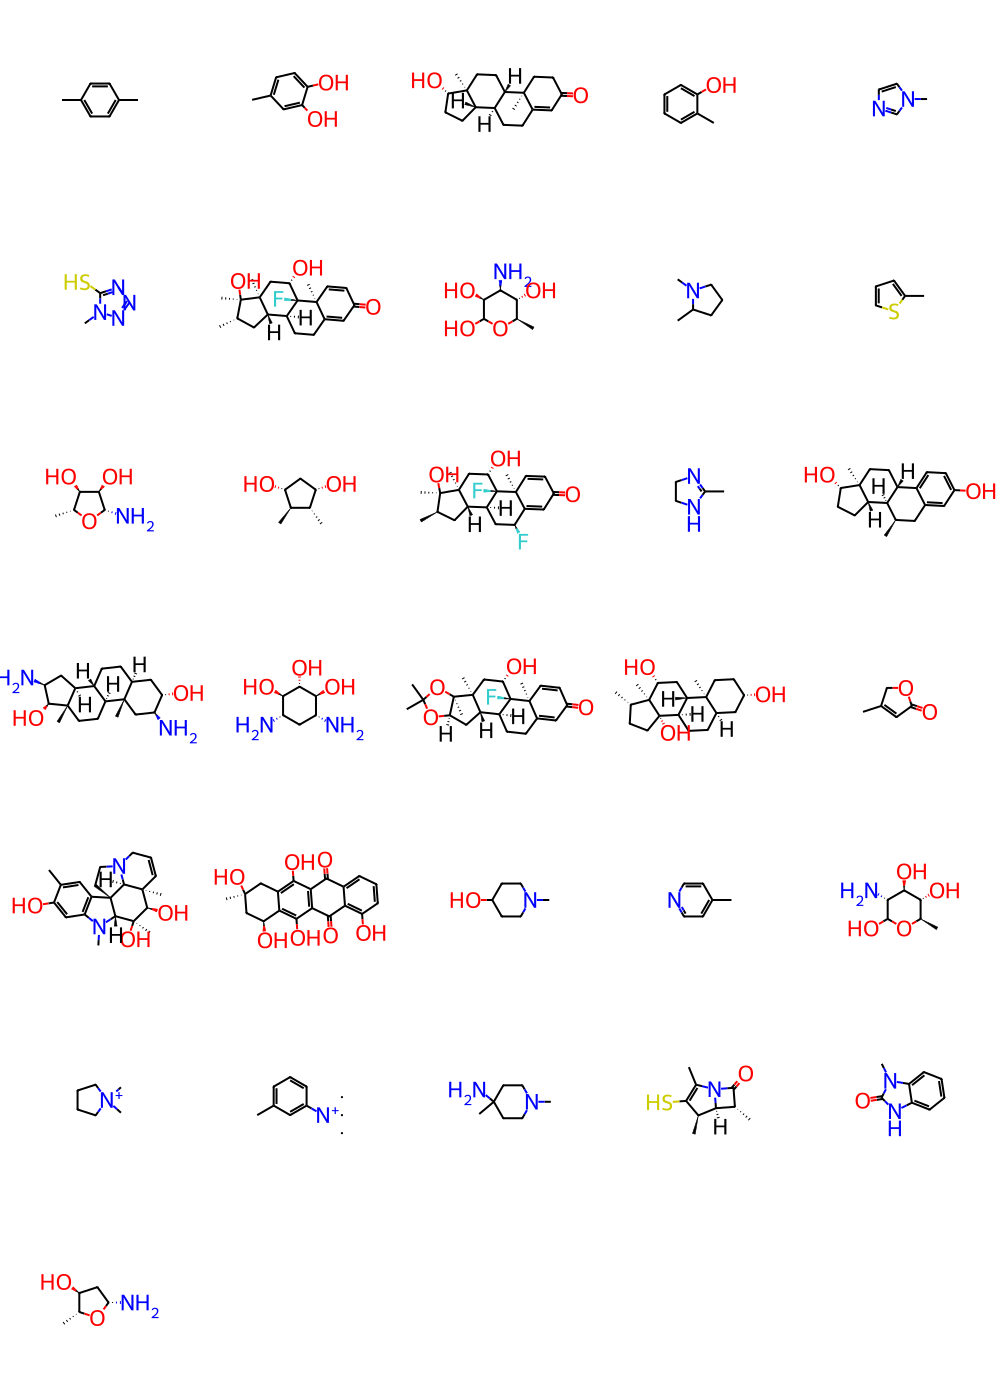

In [186]:
only_non_oral_mols = only_non_oral_fragments['mol_non_oral'].to_list()
Draw.MolsToGridImage(only_non_oral_mols, molsPerRow=5)